In [1]:
import pandas as pd 
import numpy as np
import os
dataset_folder = '../dataset_new'

In [2]:
sensors = ['sensor2', 'sensor3', 'sensor4','sensor7','sensor8','sensor9','sensor11','sensor12','sensor13','sensor14',
           'sensor15','sensor17','sensor20', 'sensor21']

In [3]:
train = []
files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('scaled')]

for file in files: 
    path_to_file = dataset_folder + '/'+file
    df = pd.read_csv(path_to_file, index_col=0) #index_col = 0 perché sennò viene aggiunta la colonna unnamed. 
    train.append(df)

train[0].head()

,unit_number,time_cycle,op_setting1,op_setting2,op_setting3,RUL,sensor2,sensor3,sensor4,sensor6,...,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,1.0,-0.0005,0.0004,100.0,258.0,0.355972,0.370523,0.308580,1.0,...,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331
1,1.0,2.0,0.0008,-0.0003,100.0,257.0,0.388759,0.399100,0.309360,1.0,...,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836
2,1.0,3.0,-0.0014,-0.0002,100.0,256.0,0.313817,0.353298,0.445398,1.0,...,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577
3,1.0,4.0,-0.0020,0.0001,100.0,255.0,0.487119,0.417107,0.237285,1.0,...,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966
4,1.0,5.0,0.0016,0.0000,100.0,254.0,0.196721,0.476218,0.321217,1.0,...,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371


In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [6]:
#Configurazione

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []

FD0001 = train[0]
unit_number_col = FD0001['unit_number']
num_train_machines_FD0001 = len(FD0001['unit_number'].unique())
FD0001 = FD0001[sensors]

In [7]:
new_FD0001 = pd.concat([unit_number_col, FD0001], axis= 1 )

In [8]:

for i in np.arange(1, num_train_machines_FD0001 + 1):
    temp_train_data = new_FD0001[new_FD0001['unit_number'] == i].drop(columns = ['unit_number']).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [9]:

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

Processed trianing data shape:  (21820, 30, 14)
Processed training ruls shape:  (21820,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=42)

In [11]:
from keras import backend as K 
import tensorflow as tf 
import math 

@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.2 # 0.4 per la large !!!
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum


def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

2023-10-09 10:06:26.822481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 10:06:28.611880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/home/aliquodfahriam/miniconda3/envs/tensorflowEnv/lib/
2023-10-09 10:06:28.612493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/

In [12]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


#Replica della rete neurale proposta come "small LSTM"
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    optimizer = Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score] )
    return model


def createLSTMlargeModel(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    optimizer = Adam(learning_rate=0.01)
    model = Sequential(layers)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score])
    return model


In [13]:
LSTMlargeModel= createLSTMlargeModel(128, 64, 32, 16, 64, 32, (30,14))

2023-10-09 10:06:29.712305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 10:06:29.754613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 10:06:29.754933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 10:06:29.756128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [14]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch >= 30 and epoch < 60 :
        return 0.001
    elif epoch >= 60 and epoch < 90: 
        return 0.0001
    elif epoch >= 90: 
        return 0.00001
    else: 
        return 0.01; 
    

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 100 

path_large = './models/LSTMlarge/FD0001'
model_checkpoint = ModelCheckpoint(
    path_large,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = LSTMlargeModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = 100,
    batch_size = 256,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, lr_scheduler])



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100


2023-10-09 10:06:35.852526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


69/69 [==============================] - ETA: 0s - loss: 1617.2249 - custom_score: 85482.1641
Epoch 1: val_loss improved from inf to 1421.53552, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 17s 171ms/step - loss: 1617.2249 - custom_score: 85482.1641 - val_loss: 1421.5355 - val_custom_score: 20451.7480 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
66/69 [===========================>..] - ETA: 0s - loss: 1455.4606 - custom_score: 22770.9355
Epoch 2: val_loss did not improve from 1421.53552
69/69 [==============================] - 1s 18ms/step - loss: 1454.7261 - custom_score: 22557.0879 - val_loss: 1426.9424 - val_custom_score: 18660.3105 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
68/69 [============================>.] - ETA: 0s - loss: 1041.9680 - custom_score: 17790.0234
Epoch 3: val_loss improved from 1421.53552 to 554.21552, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 157ms/step - loss: 1042.1825 - custom_score: 17591.2168 - val_loss: 554.2155 - val_custom_score: 8262.3623 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
66/69 [===========================>..] - ETA: 0s - loss: 585.2959 - custom_score: 8449.7207
Epoch 4: val_loss improved from 554.21552 to 538.76514, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 164ms/step - loss: 583.5457 - custom_score: 8279.8262 - val_loss: 538.7651 - val_custom_score: 5324.9224 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/100
68/69 [============================>.] - ETA: 0s - loss: 531.7199 - custom_score: 6960.4297
Epoch 5: val_loss improved from 538.76514 to 537.14441, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 162ms/step - loss: 532.6187 - custom_score: 6897.3784 - val_loss: 537.1444 - val_custom_score: 8857.0479 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 6/100
66/69 [===========================>..] - ETA: 0s - loss: 518.5644 - custom_score: 6694.6982
Epoch 6: val_loss improved from 537.14441 to 477.88409, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 171ms/step - loss: 517.1451 - custom_score: 6557.8765 - val_loss: 477.8841 - val_custom_score: 5839.7207 - lr: 0.0100

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 7/100
68/69 [============================>.] - ETA: 0s - loss: 508.6530 - custom_score: 6071.1396
Epoch 7: val_loss did not improve from 477.88409
69/69 [==============================] - 1s 19ms/step - loss: 508.0049 - custom_score: 5987.8594 - val_loss: 478.2955 - val_custom_score: 7552.0557 - lr: 0.0100

Epoch 8: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 8/100
67/69 [============================>.] - ETA: 0s - loss: 463.8192 - custom_score: 5167.0674
Epoch 8: val_loss did not improve from 477.88409
69/69 [==============================] - 1s 18ms/step - loss: 461.9953 - custom_score: 5071.7051 - val_loss: 630.3010 - val_custom_score: 5954.2207 - lr: 0.0100

Epoch 9: LearningRateScheduler setting learning ra

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 162ms/step - loss: 380.5289 - custom_score: 3390.2571 - val_loss: 312.8694 - val_custom_score: 1998.1105 - lr: 0.0100

Epoch 10: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 10/100
68/69 [============================>.] - ETA: 0s - loss: 253.7320 - custom_score: 1534.3251
Epoch 10: val_loss improved from 312.86942 to 257.16077, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 161ms/step - loss: 253.5048 - custom_score: 1514.6050 - val_loss: 257.1608 - val_custom_score: 1240.0990 - lr: 0.0100

Epoch 11: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 11/100
68/69 [============================>.] - ETA: 0s - loss: 235.6938 - custom_score: 1400.4236
Epoch 11: val_loss improved from 257.16077 to 206.75452, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 160ms/step - loss: 235.6309 - custom_score: 1382.8942 - val_loss: 206.7545 - val_custom_score: 1225.5442 - lr: 0.0100

Epoch 12: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 12/100
68/69 [============================>.] - ETA: 0s - loss: 216.5184 - custom_score: 1241.5067
Epoch 12: val_loss did not improve from 206.75452
69/69 [==============================] - 1s 18ms/step - loss: 216.9141 - custom_score: 1229.6935 - val_loss: 307.7315 - val_custom_score: 2931.2891 - lr: 0.0100

Epoch 13: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 13/100
66/69 [===========================>..] - ETA: 0s - loss: 221.7962 - custom_score: 1320.2418
Epoch 13: val_loss improved from 206.75452 to 179.24223, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 175ms/step - loss: 220.8190 - custom_score: 1304.5887 - val_loss: 179.2422 - val_custom_score: 754.9404 - lr: 0.0100

Epoch 14: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 14/100
69/69 [==============================] - ETA: 0s - loss: 187.3920 - custom_score: 1005.0264
Epoch 14: val_loss did not improve from 179.24223
69/69 [==============================] - 1s 17ms/step - loss: 187.3920 - custom_score: 1005.0264 - val_loss: 237.5976 - val_custom_score: 1967.8276 - lr: 0.0100

Epoch 15: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 15/100
69/69 [==============================] - ETA: 0s - loss: 178.4097 - custom_score: 950.3428
Epoch 15: val_loss improved from 179.24223 to 139.13557, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 167ms/step - loss: 178.4097 - custom_score: 950.3428 - val_loss: 139.1356 - val_custom_score: 605.0175 - lr: 0.0100

Epoch 16: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 16/100
66/69 [===========================>..] - ETA: 0s - loss: 164.4411 - custom_score: 861.8602
Epoch 16: val_loss did not improve from 139.13557
69/69 [==============================] - 1s 15ms/step - loss: 163.7347 - custom_score: 848.2232 - val_loss: 142.6890 - val_custom_score: 604.8572 - lr: 0.0100

Epoch 17: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 17/100
68/69 [============================>.] - ETA: 0s - loss: 153.0908 - custom_score: 789.8375
Epoch 17: val_loss did not improve from 139.13557
69/69 [==============================] - 1s 18ms/step - loss: 153.2202 - custom_score: 781.9374 - val_loss: 170.0969 - val_custom_score: 935.6008 - lr: 0.0100

Epoch 18: LearningRateScheduler setting learning rat

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 11s 167ms/step - loss: 142.4222 - custom_score: 723.6684 - val_loss: 135.5089 - val_custom_score: 693.8878 - lr: 0.0100

Epoch 20: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 20/100
67/69 [============================>.] - ETA: 0s - loss: 142.2757 - custom_score: 725.4814
Epoch 20: val_loss did not improve from 135.50888
69/69 [==============================] - 1s 17ms/step - loss: 142.1526 - custom_score: 717.2216 - val_loss: 177.3972 - val_custom_score: 813.2351 - lr: 0.0100

Epoch 21: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 21/100
68/69 [============================>.] - ETA: 0s - loss: 139.7365 - custom_score: 704.3635
Epoch 21: val_loss improved from 135.50888 to 130.26393, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 172ms/step - loss: 139.6310 - custom_score: 695.6029 - val_loss: 130.2639 - val_custom_score: 660.4039 - lr: 0.0100

Epoch 22: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 22/100
66/69 [===========================>..] - ETA: 0s - loss: 133.0450 - custom_score: 668.0787
Epoch 22: val_loss improved from 130.26393 to 128.60689, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 174ms/step - loss: 133.1838 - custom_score: 663.1280 - val_loss: 128.6069 - val_custom_score: 513.5602 - lr: 0.0100

Epoch 23: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 23/100
69/69 [==============================] - ETA: 0s - loss: 130.3203 - custom_score: 640.0727
Epoch 23: val_loss did not improve from 128.60689
69/69 [==============================] - 1s 18ms/step - loss: 130.3203 - custom_score: 640.0727 - val_loss: 148.7615 - val_custom_score: 935.4976 - lr: 0.0100

Epoch 24: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 24/100
66/69 [===========================>..] - ETA: 0s - loss: 136.3294 - custom_score: 702.5738
Epoch 24: val_loss did not improve from 128.60689
69/69 [==============================] - 1s 16ms/step - loss: 137.2850 - custom_score: 705.5687 - val_loss: 131.8562 - val_custom_score: 693.6346 - lr: 0.0100

Epoch 25: LearningRateScheduler setting learning rat

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 182ms/step - loss: 145.7352 - custom_score: 757.4366 - val_loss: 114.8273 - val_custom_score: 518.9998 - lr: 0.0100

Epoch 28: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 28/100
68/69 [============================>.] - ETA: 0s - loss: 120.1787 - custom_score: 595.0956
Epoch 28: val_loss did not improve from 114.82731
69/69 [==============================] - 1s 18ms/step - loss: 120.1094 - custom_score: 587.5465 - val_loss: 116.2808 - val_custom_score: 521.5800 - lr: 0.0100

Epoch 29: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 29/100
67/69 [============================>.] - ETA: 0s - loss: 122.1427 - custom_score: 614.4702
Epoch 29: val_loss did not improve from 114.82731
69/69 [==============================] - 1s 16ms/step - loss: 122.4284 - custom_score: 606.1420 - val_loss: 143.2081 - val_custom_score: 914.9597 - lr: 0.0100

Epoch 30: LearningRateScheduler setting learning rat

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 200ms/step - loss: 108.2850 - custom_score: 515.3697 - val_loss: 105.9948 - val_custom_score: 456.2567 - lr: 0.0010

Epoch 32: LearningRateScheduler setting learning rate to 0.001.
Epoch 32/100
69/69 [==============================] - ETA: 0s - loss: 106.5840 - custom_score: 508.0252
Epoch 32: val_loss did not improve from 105.99477
69/69 [==============================] - 1s 17ms/step - loss: 106.5840 - custom_score: 508.0252 - val_loss: 107.2659 - val_custom_score: 434.0330 - lr: 0.0010

Epoch 33: LearningRateScheduler setting learning rate to 0.001.
Epoch 33/100
66/69 [===========================>..] - ETA: 0s - loss: 105.0371 - custom_score: 504.4728
Epoch 33: val_loss improved from 105.99477 to 104.47538, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 187ms/step - loss: 105.1170 - custom_score: 499.3960 - val_loss: 104.4754 - val_custom_score: 447.3539 - lr: 0.0010

Epoch 34: LearningRateScheduler setting learning rate to 0.001.
Epoch 34/100
67/69 [============================>.] - ETA: 0s - loss: 105.4854 - custom_score: 502.9611
Epoch 34: val_loss improved from 104.47538 to 104.04959, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 190ms/step - loss: 105.4456 - custom_score: 497.3768 - val_loss: 104.0496 - val_custom_score: 478.2448 - lr: 0.0010

Epoch 35: LearningRateScheduler setting learning rate to 0.001.
Epoch 35/100
68/69 [============================>.] - ETA: 0s - loss: 103.7656 - custom_score: 504.9411
Epoch 35: val_loss did not improve from 104.04959
69/69 [==============================] - 1s 19ms/step - loss: 103.8144 - custom_score: 499.1490 - val_loss: 104.9384 - val_custom_score: 445.9597 - lr: 0.0010

Epoch 36: LearningRateScheduler setting learning rate to 0.001.
Epoch 36/100
67/69 [============================>.] - ETA: 0s - loss: 104.2597 - custom_score: 503.4512
Epoch 36: val_loss did not improve from 104.04959
69/69 [==============================] - 1s 18ms/step - loss: 104.2294 - custom_score: 496.7047 - val_loss: 105.7756 - val_custom_score: 421.4174 - lr: 0.0010

Epoch 37: LearningRateScheduler setting learning rate to 0.001.
Epoch 37/100
66/69

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 186ms/step - loss: 103.5304 - custom_score: 494.4256 - val_loss: 102.4206 - val_custom_score: 453.1453 - lr: 0.0010

Epoch 38: LearningRateScheduler setting learning rate to 0.001.
Epoch 38/100
69/69 [==============================] - ETA: 0s - loss: 102.4963 - custom_score: 488.3152
Epoch 38: val_loss did not improve from 102.42058
69/69 [==============================] - 1s 20ms/step - loss: 102.4963 - custom_score: 488.3152 - val_loss: 102.6575 - val_custom_score: 447.4586 - lr: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.001.
Epoch 39/100
66/69 [===========================>..] - ETA: 0s - loss: 101.6734 - custom_score: 488.6638
Epoch 39: val_loss improved from 102.42058 to 102.31418, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 189ms/step - loss: 101.8142 - custom_score: 483.0696 - val_loss: 102.3142 - val_custom_score: 435.0882 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.001.
Epoch 40/100
67/69 [============================>.] - ETA: 0s - loss: 101.4219 - custom_score: 487.6977
Epoch 40: val_loss improved from 102.31418 to 101.26082, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 181ms/step - loss: 101.3874 - custom_score: 481.4217 - val_loss: 101.2608 - val_custom_score: 422.5554 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.001.
Epoch 41/100
69/69 [==============================] - ETA: 0s - loss: 100.9278 - custom_score: 481.6888
Epoch 41: val_loss improved from 101.26082 to 99.88981, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 12s 177ms/step - loss: 100.9278 - custom_score: 481.6888 - val_loss: 99.8898 - val_custom_score: 428.1322 - lr: 0.0010

Epoch 42: LearningRateScheduler setting learning rate to 0.001.
Epoch 42/100
69/69 [==============================] - ETA: 0s - loss: 101.4885 - custom_score: 486.7904
Epoch 42: val_loss did not improve from 99.88981
69/69 [==============================] - 1s 18ms/step - loss: 101.4885 - custom_score: 486.7904 - val_loss: 104.3358 - val_custom_score: 406.2866 - lr: 0.0010

Epoch 43: LearningRateScheduler setting learning rate to 0.001.
Epoch 43/100
66/69 [===========================>..] - ETA: 0s - loss: 100.6942 - custom_score: 485.7617
Epoch 43: val_loss improved from 99.88981 to 99.48437, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 190ms/step - loss: 100.3633 - custom_score: 477.5915 - val_loss: 99.4844 - val_custom_score: 428.7312 - lr: 0.0010

Epoch 44: LearningRateScheduler setting learning rate to 0.001.
Epoch 44/100
66/69 [===========================>..] - ETA: 0s - loss: 98.9887 - custom_score: 478.5623
Epoch 44: val_loss improved from 99.48437 to 99.07935, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 220ms/step - loss: 99.7793 - custom_score: 475.1161 - val_loss: 99.0793 - val_custom_score: 418.6058 - lr: 0.0010

Epoch 45: LearningRateScheduler setting learning rate to 0.001.
Epoch 45/100
68/69 [============================>.] - ETA: 0s - loss: 99.7404 - custom_score: 479.4697
Epoch 45: val_loss improved from 99.07935 to 97.08984, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 228ms/step - loss: 99.6703 - custom_score: 473.1960 - val_loss: 97.0898 - val_custom_score: 429.0013 - lr: 0.0010

Epoch 46: LearningRateScheduler setting learning rate to 0.001.
Epoch 46/100
69/69 [==============================] - ETA: 0s - loss: 100.9778 - custom_score: 489.0491
Epoch 46: val_loss did not improve from 97.08984
69/69 [==============================] - 1s 17ms/step - loss: 100.9778 - custom_score: 489.0491 - val_loss: 102.5760 - val_custom_score: 386.8734 - lr: 0.0010

Epoch 47: LearningRateScheduler setting learning rate to 0.001.
Epoch 47/100
67/69 [============================>.] - ETA: 0s - loss: 98.9163 - custom_score: 468.2899
Epoch 47: val_loss did not improve from 97.08984
69/69 [==============================] - 1s 16ms/step - loss: 98.8630 - custom_score: 463.8959 - val_loss: 97.6493 - val_custom_score: 420.4540 - lr: 0.0010

Epoch 48: LearningRateScheduler setting learning rate to 0.001.
Epoch 48/100
68/69 [=====

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 214ms/step - loss: 98.2564 - custom_score: 463.8823 - val_loss: 96.2467 - val_custom_score: 419.6570 - lr: 0.0010

Epoch 49: LearningRateScheduler setting learning rate to 0.001.
Epoch 49/100
66/69 [===========================>..] - ETA: 0s - loss: 96.3762 - custom_score: 462.2660
Epoch 49: val_loss improved from 96.24673 to 95.00159, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 197ms/step - loss: 96.5151 - custom_score: 458.3040 - val_loss: 95.0016 - val_custom_score: 427.7294 - lr: 0.0010

Epoch 50: LearningRateScheduler setting learning rate to 0.001.
Epoch 50/100
67/69 [============================>.] - ETA: 0s - loss: 96.4560 - custom_score: 465.8701
Epoch 50: val_loss improved from 95.00159 to 94.17104, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 13s 196ms/step - loss: 96.4709 - custom_score: 460.3507 - val_loss: 94.1710 - val_custom_score: 395.2187 - lr: 0.0010

Epoch 51: LearningRateScheduler setting learning rate to 0.001.
Epoch 51/100
66/69 [===========================>..] - ETA: 0s - loss: 95.1216 - custom_score: 460.5246
Epoch 51: val_loss did not improve from 94.17104
69/69 [==============================] - 1s 15ms/step - loss: 95.2120 - custom_score: 454.9342 - val_loss: 95.1195 - val_custom_score: 401.2395 - lr: 0.0010

Epoch 52: LearningRateScheduler setting learning rate to 0.001.
Epoch 52/100
69/69 [==============================] - ETA: 0s - loss: 96.1650 - custom_score: 455.4749
Epoch 52: val_loss did not improve from 94.17104
69/69 [==============================] - 1s 16ms/step - loss: 96.1650 - custom_score: 455.4749 - val_loss: 99.4241 - val_custom_score: 372.2878 - lr: 0.0010

Epoch 53: LearningRateScheduler setting learning rate to 0.001.
Epoch 53/100
69/69 [========

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 199ms/step - loss: 93.9564 - custom_score: 441.4082 - val_loss: 92.5657 - val_custom_score: 373.3924 - lr: 0.0010

Epoch 56: LearningRateScheduler setting learning rate to 0.001.
Epoch 56/100
69/69 [==============================] - ETA: 0s - loss: 91.8443 - custom_score: 431.5979
Epoch 56: val_loss improved from 92.56570 to 90.91587, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 200ms/step - loss: 91.8443 - custom_score: 431.5979 - val_loss: 90.9159 - val_custom_score: 396.7122 - lr: 0.0010

Epoch 57: LearningRateScheduler setting learning rate to 0.001.
Epoch 57/100
69/69 [==============================] - ETA: 0s - loss: 91.5663 - custom_score: 436.1663
Epoch 57: val_loss did not improve from 90.91587
69/69 [==============================] - 1s 18ms/step - loss: 91.5663 - custom_score: 436.1663 - val_loss: 94.5266 - val_custom_score: 379.4694 - lr: 0.0010

Epoch 58: LearningRateScheduler setting learning rate to 0.001.
Epoch 58/100
68/69 [============================>.] - ETA: 0s - loss: 90.9963 - custom_score: 432.8577
Epoch 58: val_loss improved from 90.91587 to 89.38029, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 204ms/step - loss: 91.0522 - custom_score: 428.4083 - val_loss: 89.3803 - val_custom_score: 368.9012 - lr: 0.0010

Epoch 59: LearningRateScheduler setting learning rate to 0.001.
Epoch 59/100
67/69 [============================>.] - ETA: 0s - loss: 90.8306 - custom_score: 431.0917
Epoch 59: val_loss did not improve from 89.38029
69/69 [==============================] - 1s 17ms/step - loss: 90.7206 - custom_score: 426.1579 - val_loss: 90.0416 - val_custom_score: 363.8601 - lr: 0.0010

Epoch 60: LearningRateScheduler setting learning rate to 0.001.
Epoch 60/100
68/69 [============================>.] - ETA: 0s - loss: 90.6939 - custom_score: 436.8220
Epoch 60: val_loss did not improve from 89.38029
69/69 [==============================] - 1s 17ms/step - loss: 90.7650 - custom_score: 432.1150 - val_loss: 92.5629 - val_custom_score: 353.2655 - lr: 0.0010

Epoch 61: LearningRateScheduler setting learning rate to 0.0001.
Epoch 61/100
68/69 [=======

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 201ms/step - loss: 86.9015 - custom_score: 400.1850 - val_loss: 87.4211 - val_custom_score: 358.3069 - lr: 1.0000e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.0001.
Epoch 62/100
66/69 [===========================>..] - ETA: 0s - loss: 85.2803 - custom_score: 398.0260
Epoch 62: val_loss improved from 87.42110 to 86.38190, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 202ms/step - loss: 85.4663 - custom_score: 394.3299 - val_loss: 86.3819 - val_custom_score: 358.1927 - lr: 1.0000e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.0001.
Epoch 63/100
66/69 [===========================>..] - ETA: 0s - loss: 85.2643 - custom_score: 401.4178
Epoch 63: val_loss did not improve from 86.38190
69/69 [==============================] - 1s 15ms/step - loss: 85.2828 - custom_score: 397.1441 - val_loss: 87.2662 - val_custom_score: 348.0319 - lr: 1.0000e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0001.
Epoch 64/100
67/69 [============================>.] - ETA: 0s - loss: 85.2690 - custom_score: 401.5991
Epoch 64: val_loss did not improve from 86.38190
69/69 [==============================] - 1s 19ms/step - loss: 85.4141 - custom_score: 396.6838 - val_loss: 86.9978 - val_custom_score: 349.9479 - lr: 1.0000e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0001.
Epoch 65/100


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 210ms/step - loss: 84.9941 - custom_score: 393.5110 - val_loss: 86.0128 - val_custom_score: 351.8455 - lr: 1.0000e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0001.
Epoch 66/100
67/69 [============================>.] - ETA: 0s - loss: 84.3667 - custom_score: 394.9710
Epoch 66: val_loss improved from 86.01283 to 85.53661, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 208ms/step - loss: 84.1064 - custom_score: 388.6256 - val_loss: 85.5366 - val_custom_score: 353.6365 - lr: 1.0000e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0001.
Epoch 67/100
68/69 [============================>.] - ETA: 0s - loss: 84.8323 - custom_score: 396.5363
Epoch 67: val_loss did not improve from 85.53661
69/69 [==============================] - 1s 17ms/step - loss: 84.7841 - custom_score: 391.5467 - val_loss: 86.9620 - val_custom_score: 354.5003 - lr: 1.0000e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0001.
Epoch 68/100
68/69 [============================>.] - ETA: 0s - loss: 84.7560 - custom_score: 396.2713
Epoch 68: val_loss did not improve from 85.53661
69/69 [==============================] - 1s 17ms/step - loss: 84.6290 - custom_score: 391.0152 - val_loss: 85.6443 - val_custom_score: 357.9332 - lr: 1.0000e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0001.
Epoch 69/100


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 208ms/step - loss: 83.5291 - custom_score: 386.1378 - val_loss: 85.0220 - val_custom_score: 357.1144 - lr: 1.0000e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0001.
Epoch 70/100
67/69 [============================>.] - ETA: 0s - loss: 84.1628 - custom_score: 394.0663
Epoch 70: val_loss did not improve from 85.02197
69/69 [==============================] - 1s 19ms/step - loss: 84.1925 - custom_score: 389.3585 - val_loss: 85.3249 - val_custom_score: 345.5533 - lr: 1.0000e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.0001.
Epoch 71/100
66/69 [===========================>..] - ETA: 0s - loss: 83.6766 - custom_score: 389.5169
Epoch 71: val_loss improved from 85.02197 to 84.39936, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 223ms/step - loss: 83.7757 - custom_score: 385.2601 - val_loss: 84.3994 - val_custom_score: 364.0531 - lr: 1.0000e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.0001.
Epoch 72/100
69/69 [==============================] - ETA: 0s - loss: 83.5237 - custom_score: 386.2028
Epoch 72: val_loss improved from 84.39936 to 84.39560, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 216ms/step - loss: 83.5237 - custom_score: 386.2028 - val_loss: 84.3956 - val_custom_score: 361.0158 - lr: 1.0000e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.0001.
Epoch 73/100
66/69 [===========================>..] - ETA: 0s - loss: 84.1350 - custom_score: 394.8718
Epoch 73: val_loss did not improve from 84.39560
69/69 [==============================] - 1s 19ms/step - loss: 84.3658 - custom_score: 390.8217 - val_loss: 84.6532 - val_custom_score: 345.3884 - lr: 1.0000e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.0001.
Epoch 74/100
66/69 [===========================>..] - ETA: 0s - loss: 84.0481 - custom_score: 396.4564
Epoch 74: val_loss did not improve from 84.39560
69/69 [==============================] - 1s 18ms/step - loss: 83.8859 - custom_score: 390.2373 - val_loss: 84.4846 - val_custom_score: 343.9718 - lr: 1.0000e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0001.
Epoch 75/100


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 225ms/step - loss: 82.8788 - custom_score: 383.1228 - val_loss: 83.6793 - val_custom_score: 364.0463 - lr: 1.0000e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0001.
Epoch 77/100
65/69 [===========================>..] - ETA: 0s - loss: 83.2236 - custom_score: 391.8575
Epoch 77: val_loss did not improve from 83.67925
69/69 [==============================] - 1s 16ms/step - loss: 82.9922 - custom_score: 386.9999 - val_loss: 84.8428 - val_custom_score: 342.4715 - lr: 1.0000e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0001.
Epoch 78/100
69/69 [==============================] - ETA: 0s - loss: 83.4562 - custom_score: 383.9613
Epoch 78: val_loss improved from 83.67925 to 83.62564, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 213ms/step - loss: 83.4562 - custom_score: 383.9613 - val_loss: 83.6256 - val_custom_score: 366.7660 - lr: 1.0000e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.0001.
Epoch 79/100
69/69 [==============================] - ETA: 0s - loss: 82.8414 - custom_score: 388.6635
Epoch 79: val_loss did not improve from 83.62564
69/69 [==============================] - 1s 16ms/step - loss: 82.8414 - custom_score: 388.6635 - val_loss: 84.6777 - val_custom_score: 342.7039 - lr: 1.0000e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.0001.
Epoch 80/100
68/69 [============================>.] - ETA: 0s - loss: 82.1673 - custom_score: 384.6727
Epoch 80: val_loss improved from 83.62564 to 83.39458, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 221ms/step - loss: 82.1873 - custom_score: 380.0045 - val_loss: 83.3946 - val_custom_score: 345.1620 - lr: 1.0000e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.0001.
Epoch 81/100
69/69 [==============================] - ETA: 0s - loss: 82.3670 - custom_score: 379.1690
Epoch 81: val_loss did not improve from 83.39458
69/69 [==============================] - 1s 17ms/step - loss: 82.3670 - custom_score: 379.1690 - val_loss: 83.8292 - val_custom_score: 342.2980 - lr: 1.0000e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.0001.
Epoch 82/100
66/69 [===========================>..] - ETA: 0s - loss: 82.9283 - custom_score: 387.3536
Epoch 82: val_loss improved from 83.39458 to 83.36033, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 14s 199ms/step - loss: 82.7080 - custom_score: 382.2222 - val_loss: 83.3603 - val_custom_score: 353.3098 - lr: 1.0000e-04

Epoch 83: LearningRateScheduler setting learning rate to 0.0001.
Epoch 83/100
69/69 [==============================] - ETA: 0s - loss: 81.7427 - custom_score: 379.1567
Epoch 83: val_loss improved from 83.36033 to 82.44065, saving model to ./models/LSTMlarge/FD0001


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 15s 220ms/step - loss: 81.7427 - custom_score: 379.1567 - val_loss: 82.4407 - val_custom_score: 348.7159 - lr: 1.0000e-04

Epoch 84: LearningRateScheduler setting learning rate to 0.0001.
Epoch 84/100
66/69 [===========================>..] - ETA: 0s - loss: 81.8474 - custom_score: 384.9342
Epoch 84: val_loss did not improve from 82.44065
69/69 [==============================] - 1s 18ms/step - loss: 82.1619 - custom_score: 381.3242 - val_loss: 83.9184 - val_custom_score: 338.4627 - lr: 1.0000e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.0001.
Epoch 85/100
66/69 [===========================>..] - ETA: 0s - loss: 82.3133 - custom_score: 386.2236
Epoch 85: val_loss did not improve from 82.44065
69/69 [==============================] - 1s 16ms/step - loss: 82.2513 - custom_score: 381.3965 - val_loss: 84.4513 - val_custom_score: 332.5252 - lr: 1.0000e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.0001.
Epoch 86/100


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 17s 245ms/step - loss: 82.1201 - custom_score: 378.7327 - val_loss: 82.3351 - val_custom_score: 348.4250 - lr: 1.0000e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.0001.
Epoch 87/100
66/69 [===========================>..] - ETA: 0s - loss: 81.7648 - custom_score: 383.7317
Epoch 87: val_loss did not improve from 82.33506
69/69 [==============================] - 1s 19ms/step - loss: 81.5667 - custom_score: 378.5629 - val_loss: 82.8990 - val_custom_score: 340.7933 - lr: 1.0000e-04

Epoch 88: LearningRateScheduler setting learning rate to 0.0001.
Epoch 88/100
69/69 [==============================] - ETA: 0s - loss: 81.5322 - custom_score: 375.0115
Epoch 88: val_loss did not improve from 82.33506
69/69 [==============================] - 1s 18ms/step - loss: 81.5322 - custom_score: 375.0115 - val_loss: 83.8267 - val_custom_score: 327.0836 - lr: 1.0000e-04

Epoch 89: LearningRateScheduler setting learning rate to 0.0001.
Epoch 89/100


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


69/69 [==============================] - 24s 353ms/step - loss: 81.3417 - custom_score: 373.0995 - val_loss: 81.8777 - val_custom_score: 350.0769 - lr: 1.0000e-04

Epoch 91: LearningRateScheduler setting learning rate to 1e-05.
Epoch 91/100
69/69 [==============================] - ETA: 0s - loss: 80.6362 - custom_score: 376.8768
Epoch 91: val_loss did not improve from 81.87769
69/69 [==============================] - 1s 17ms/step - loss: 80.6362 - custom_score: 376.8768 - val_loss: 82.1956 - val_custom_score: 337.6967 - lr: 1.0000e-05

Epoch 92: LearningRateScheduler setting learning rate to 1e-05.
Epoch 92/100
68/69 [============================>.] - ETA: 0s - loss: 80.8693 - custom_score: 375.8182
Epoch 92: val_loss did not improve from 81.87769
69/69 [==============================] - 1s 18ms/step - loss: 80.8691 - custom_score: 371.1851 - val_loss: 81.9044 - val_custom_score: 339.4553 - lr: 1.0000e-05

Epoch 93: LearningRateScheduler setting learning rate to 1e-05.
Epoch 93/100
67/

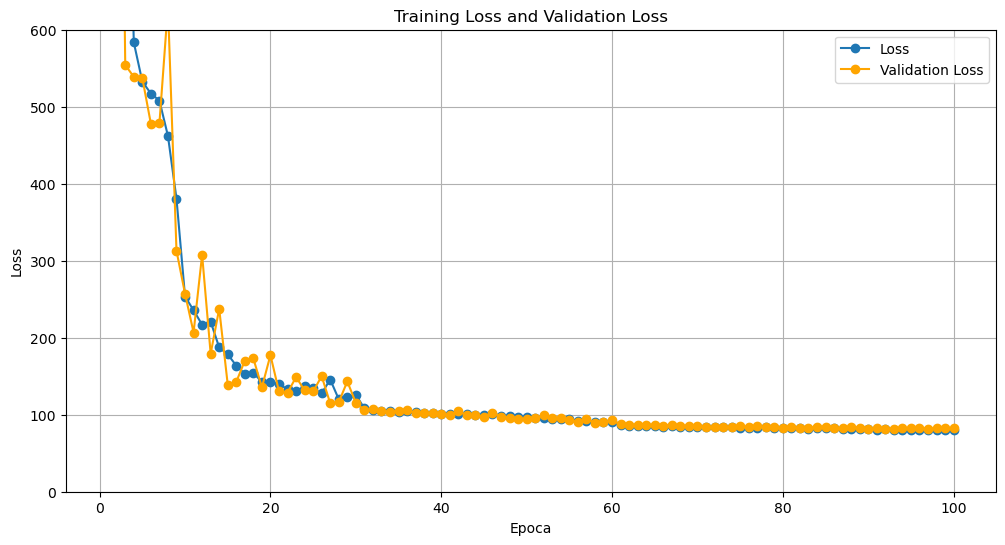

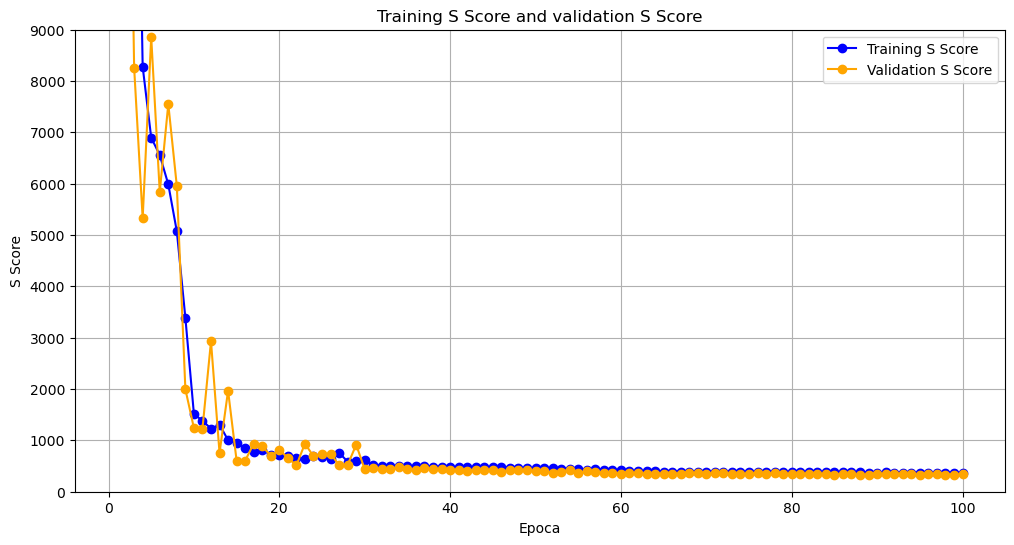

In [16]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']


custom_score_values = history.history['custom_score']  
custom_score_validation_values = history.history['val_custom_score']


# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

# Plot della custom score
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0, 9000)
plt.legend()
plt.grid(True)
plt.show()


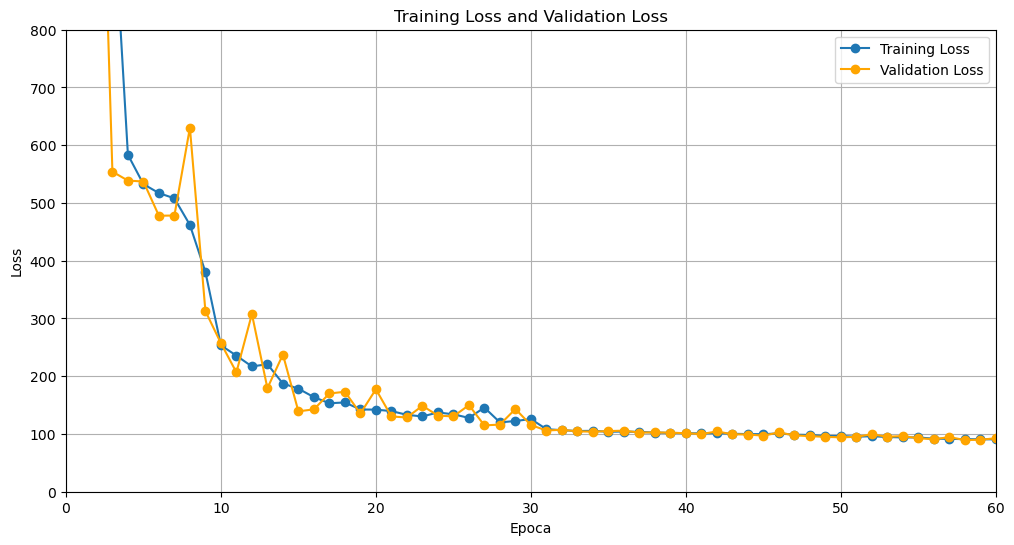

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0,800)
plt.xlim(0,60)
plt.legend()
plt.grid(True)
plt.show()


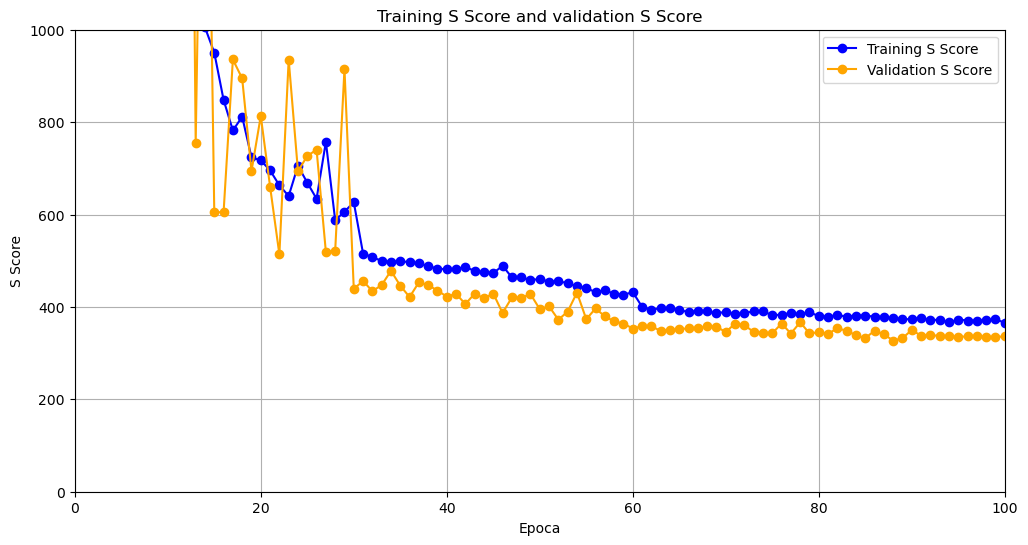

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0,1000)
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.show()

In [31]:
### FUNZIONA
MODEL_DIR = '/home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001'
run_model = tf.function(lambda x: LSTMlargeModel(x))
BATCH_SIZE = 256
STEPS = 30
INPUT_SIZE = 14

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], LSTMlargeModel.inputs[0].dtype)
)
converter = tf.lite.TFLiteConverter.from_keras_model(LSTMlargeModel)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


LSTMlargeModel.save(MODEL_DIR, save_format="tf", signatures = concrete_func )

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

with open("large_lstm.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001/assets
2023-10-09 11:02:33.375882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-10-09 11:02:33.375910: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-10-09 11:02:33.376053: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001
2023-10-09 11:02:33.409030: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-10-09 11:02:33.409069: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001
2023-10-09 11:02:33.522344: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-10-09 11:02:33.757789: I ten

: 